# Quick notebook to plot various variables from btrack
 
With explanations to understand what effect changing such variables will have on the tracker

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import math
plt.rcParams["figure.figsize"] = (15,7)

## hypothesis.cc

This C++ script iterates over tracklets to test ``trks_to_test`` and calculates various hypotheses for each track. It does this by first looping through the trajectories ``m_num_tracks``, pulling individual tracks and calculating the false positive hypothesis, the initialisation and termination hypothesis and the dead hypothesis. 

```
// loop through trajectories
for (size_t i=0; i<m_num_tracks; i++) {

    // get the test track
    trk = m_tracks[i];

    // calculate the false positive hypothesis
    hypothesis_false_positive(trk);

    // calculate initialization and termination hypotheses
    hypothesis_init(trk);
    hypothesis_term(trk);

    // calculate the death hypotheis
    hypothesis_dead(trk);
```

### Probability of false positive 

btrack hypothesis engine creates hypotheses for each of the tracklets in order to perofrm a global optimisation. All tracklets are assigned a default hypothesis, that they are a false positive detection with 

$P(FP) = m^{l}$ 

where $m$ is the segmentation miss rate and $l$ is the length of the tracklet

Text(0, 0.5, 'Probability track is assigned false positive')

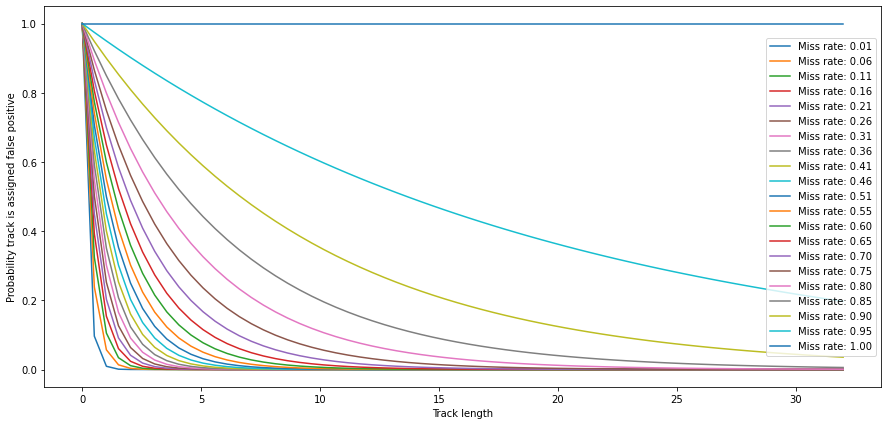

In [99]:
m = np.linspace(0.01,1,21)
l = np.linspace(0,32, 64)

for mi in m:
    plt.plot(l, mi**l, label = f'Miss rate: {mi:.2f}')
plt.legend()
plt.xlabel('Track length')
plt.ylabel('Probability track is assigned false positive')

Text(0, 0.5, 'Probability track is assigned false positive')

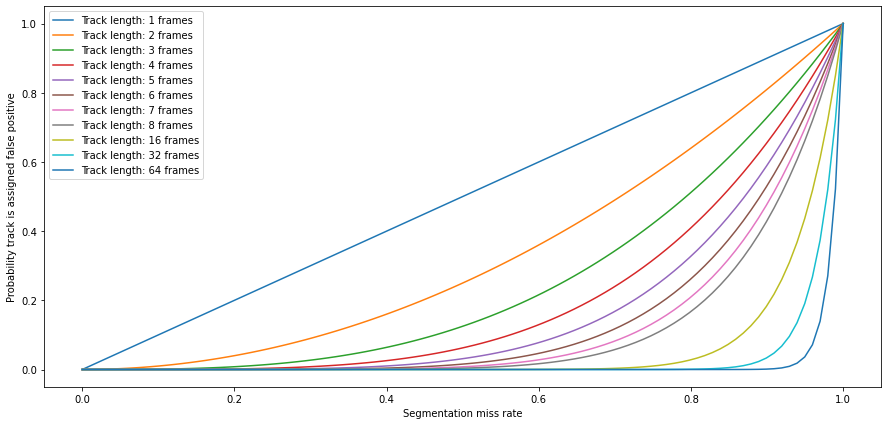

In [86]:
m = np.linspace(0,1,100)
l = [1, 2, 3, 4,5,6,7, 8, 16, 32, 64]

for li in l:
    plt.plot(m, m**li, label = f'Track length: {li} frames')
plt.legend()
plt.xlabel('Segmentation miss rate')
plt.ylabel('Probability track is assigned false positive')

##### i.e. the shorter the tracklet or the higher the segmentation miss rate, the more likely it is to be a false positive.

Following on from this, we can define the true positive probability of a track to be:

$P(TP) = 1 - P(FP)$

##### All subsequent hypotheses invoke the probability of being a true positive match as well as the calculation of various other hypotheses!

### Initialisation hypothesis

The initialisation calculation is a combination of the probability of initialisation and the probability of the tracklet being a true positive. 

The probability of initialisation is calculated as either being a border initialisation or a front
temporal initialisation, whichever is most likely.

$P(\text{init_front}) = e^{\frac{-\delta t}{\lambda_{time}}}$

$P(\text{init_border}) = e^{\frac{-d}{\lambda_{dist}}}$

Where $\delta t$ is the time since the beginning of the movie and $d$ is the distance from the border. 

Importantly, these probabilities are only calculated if the values for $\delta t$ and $d$ are within $\theta_{time}$ and $\theta_{distance}$ respectively (values set in the configuration file). This can be circumvented by setting the ``relax`` parameter to on. 

Plotting a generalised version of both of the above equations shows us the effect the that the spatiotemporal distance has on the probability of the initialisation hypothesis.

Text(0, 0.5, 'Probability tracklets are classified as initialised')

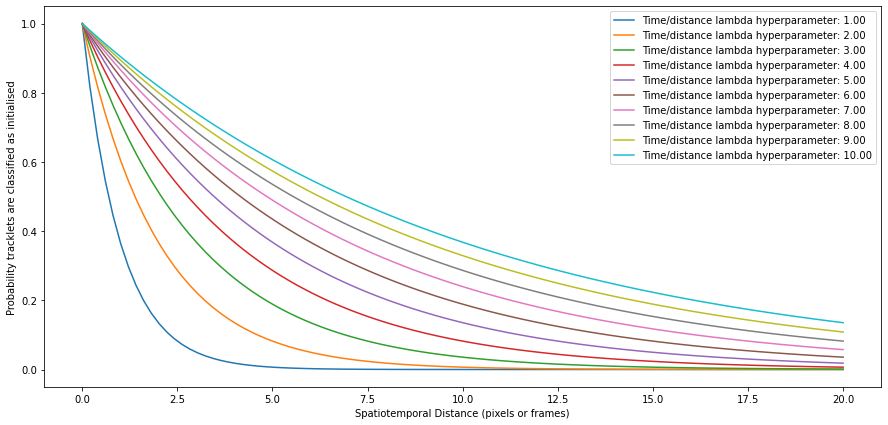

In [119]:
d = np.linspace(0,20,100)
lambda_ = np.linspace(1,10,10) #[1, 2, 3, 4,5,6,7, 8, 16, 32, 64]

for lambd in lambda_:
    P_link = np.exp(-d/lambd)
    plt.plot(d, P_link, label = f'Time/distance lambda hyperparameter: {lambd:.2f}')
plt.legend()
plt.xlabel('Spatiotemporal Distance (pixels or frames)')
plt.ylabel('Probability tracklets are classified as initialised')

The larger the lambda hyperparameter, the lower the likelihood that a tracklet will be classified as initialising and the larger the distance (either in space or time) from the boundary, the less likely it is that the tracklet will be classified as falsely initialising. 

#### Termination hypothesis

The termination hypothesis is functionally the same as the initialisation hypothesis, with the spatiotemporal distance just calculated the other way round, ie instead of the start of the timelapse it measures against the end, and instead of coming from the border it enters the border. It uses the same parameters as the initialisation!

### Dead hypothesis

The dead hypothesis invokes an apoptotic rate set in the configuration and the number of apoptosis classification counts in the tracklet. 

$P(\text{apoptosis}) = 1 - r^{N_{apop}}$

Where $r$ is the apoptotic rate and $N_{apop}$ is the number of apoptoses.

Text(0, 0.5, 'Probability tracklet is apoptotic')

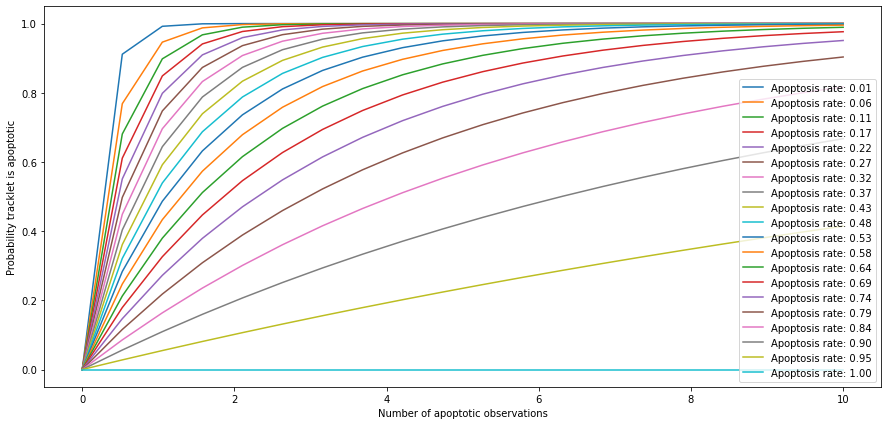

In [127]:
N = np.linspace(0,10,20)
r = np.linspace(0.01,1,20) #[1, 2, 3, 4,5,6,7, 8, 16, 32, 64]

for ri in r:
    P_apop = 1 - ri**N
    plt.plot(N, P_apop, label = f'Apoptosis rate: {ri:.2f}')
plt.legend()
plt.xlabel('Number of apoptotic observations')
plt.ylabel('Probability tracklet is apoptotic')

As can be seen, the larger the apoptotic rate and the greater the number of apoptotic observations, the more likely it is that the tracklet will be classified as apoptotic. 

## Linking and branching hypotheses

Once the previous four types of hypotheses have been generated for the tracklets, they are further iterated over within the current iteration to test track $t_{i}$ and $t_{j}$ for linking and branching hypotheses (this is because two tracklets need to be compared to if they form a link or branch).

```
// loop through trajectories
  for (size_t i=0; i<m_num_tracks; i++) {

    ... // previous code block shown above

    for (size_t j=0; j<trks_to_test.size(); j++) {
      // get the track
      TrackletPtr this_trk = trks_to_test[j];

      // make sure we don't check against the same track!
      if (trk->ID == this_trk->ID) continue;

      // calculate the time and distance between this track and the reference
      float d = link_distance(trk, this_trk);
      float dt = link_time(trk, this_trk);

      // if we exceed these continue
      if (d  > m_params.dist_thresh) continue;
      if (dt > m_params.time_thresh || dt < 1) continue; // this was one

      // calculate the linkage hypothesis
      hypothesis_link(trk, this_trk);

      // append this to conflicts
      conflicts.push_back( this_trk );

    } // j

    // if we have conflicts, this may mean divisions have occurred
    if (conflicts.size() < 2) continue;

    // iterate through the conflicts and put division hypotheses into the
    // list, including links to the children
    for (unsigned int p=0; p<conflicts.size()-1; p++) {
      // get the first putative child
      TrackletPtr trk_c0 = conflicts[p];

      for (unsigned int q=p+1; q<conflicts.size(); q++) {
        // get the second putative child
        TrackletPtr trk_c1 = conflicts[q];

        // calculate the division hypothesis
        hypothesis_branch(trk, trk_c0, trk_c1);
```

### Broken track linking hypothesis

In the linking step, the tracker finds all tracklets starting within a spatiotemporal bin surrounding hte end of a tracklet. For each initialising tracklet $t_{j}$ within that window, a linking hypothesis is proposed originating from the terminating tracklet $t_{i}$. 

$P(\text{link}:t_{i} -> t_{j}) = e^{(\frac{-d}{\lambda_{link}})}$

where $d$ is the Euclidean distance between $t_{i}$ and $t_{j}$ and $\lambda_{link}$ is a linking hyperparameter

Text(0, 0.5, 'Probability tracklets $t_{i}$ and $t_{j}$ are linked')

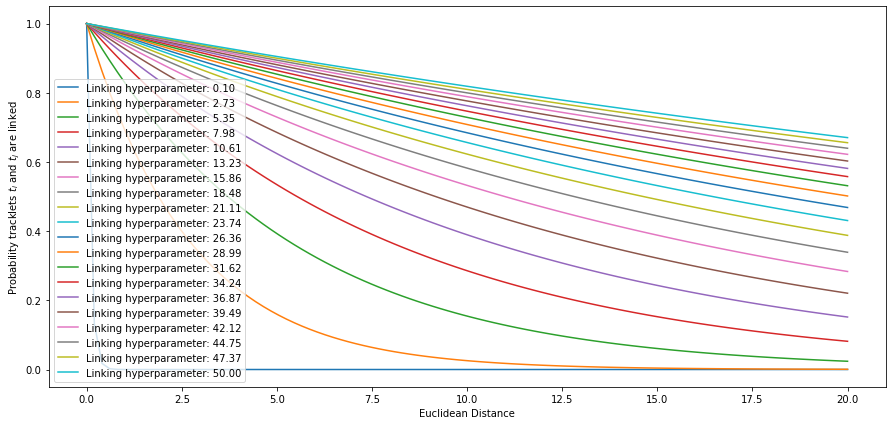

In [61]:
d = np.linspace(0,20,100)
lambda_link = np.linspace(0.1,50,20) #[1, 2, 3, 4,5,6,7, 8, 16, 32, 64]

for lambd in lambda_link:
    P_link = np.exp(-d/lambd)
    plt.plot(d, P_link, label = f'Linking hyperparameter: {lambd:.2f}')
plt.legend()
plt.xlabel('Euclidean Distance')
plt.ylabel('Probability tracklets $t_{i}$ and $t_{j}$ are linked')

The linking expression actually has an additional factor, $\delta_{link}$, in it that sets the probability of linking to zero if the cell state classifications of $t_{i}$ and $t_{j}$ don't agree chronologically (i.e. if the tracklet ends in meta/prometaphase and the new tracklet starts with anaphase).

$P(\text{link}:t_{i} -> t_{j}) = e^{(\frac{-d\times\delta_{link}}{\lambda_{link}})}$

### Branching hypothesis

In an event such as mitosis, there may exist two tracklets within a spatiotemporal bin of the end of another tracklet. If there are greater than two initialising tracklets, then for each possible pair of initialising tracklets $t_{j}$ and $t_{k}$ a branching hypothesis is proposed from the terminating tracklet $t_{i}$:

$P(\text{branch}:t_{i} -> t_{j},t_{k}) = e^{(\frac{-d_{daughter}*\delta_{branch}}{\lambda_{branch}})}$

where $d_{daughter}$ is a dot product distance representing the angle between daughter cells $t_{j}$ and $t_{k}$ and the parent cell $t_{i}$ $\textbf{and}$ the respective states of each cell.

$d_{daughter} = \vec a\cdot \vec b = \vert a\vert\vert b\vert cos \theta$

Where $\vec a$ and $\vec b$ are normalised vectors representing the distance between the end of $t_{i}$ and the beginning of $t_{j}, t_{k}$. 

If the angle $\theta$ is 180 then naturally the dot product will be -1, resulting in an ideal weighting where the daughter cells are geometrically moving away from the parent cell. 
This dot product is then scaled between 0 and -1 using an error function:

$d_{daughter} = 1 - \frac{1-erf(3\vec a\cdot \vec b)}{2}$ 


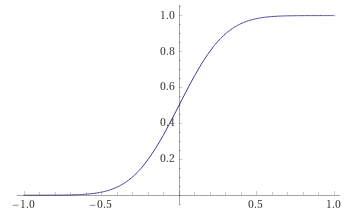

This distribution is again scaled by a hyperparameter $\lambda_{branch}$ and by an additional $\delta_{branch}$. The weight $\lambda_{branch}$ increases the distance over which two cells are likely to be accepted as branched and the $\delta_{branch}$ acts as a weighting to zero the probability if the cell states do not agree chronologically.

Text(0, 0.5, 'Probability tracklets $t_{j}$ and $t_{k}$ are branched from $t_{i}$')

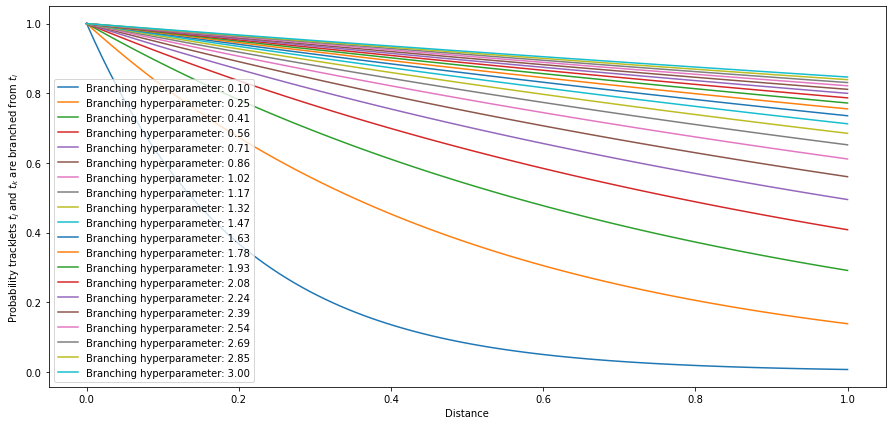

In [81]:
d = np.linspace(0,1,100)
lambda_branch = np.linspace(0.1,3,20) #[1, 2, 3, 4,5,6,7, 8, 16, 32, 64]

for lambd in lambda_branch:
    P_link = np.exp(-d/(2*lambd))
    plt.plot(d, P_link, label = f'Branching hyperparameter: {lambd:.2f}')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Probability tracklets $t_{j}$ and $t_{k}$ are branched from $t_{i}$')

### Other thresholds

In the configuration .json file there are also other parameters that dictate:

``time_thresh`` = Temporal bin size for considering hypotheses, larger bin size generates more hypotheses for each tracklet.

``dist_thresh`` = Isotropic spatial bin size for considering hypotheses, larger "..." 

``apop_thresh`` = Number of apoptotic detections to be considered a real apoptosis (counted from back).

Setting ``relax = True`` disables the theta_dist and theta_time thresholds when creating termination and initialization hypotheses. This means that tracks can initialize or terminate anywhere (or time) in the dataset.

# Hypotheses have been calculated, now how are they factored in to the Kalman filter?

1. Objects --> Kalman filter, Bayesian Updates, Linking --> Tracklets
2. Tracklets --> Hypotheses, Global Optimization --> Tracks

An integral part of the Kalman filter is the motion model, which has it's own parameters, here is the description from the online documentation. 


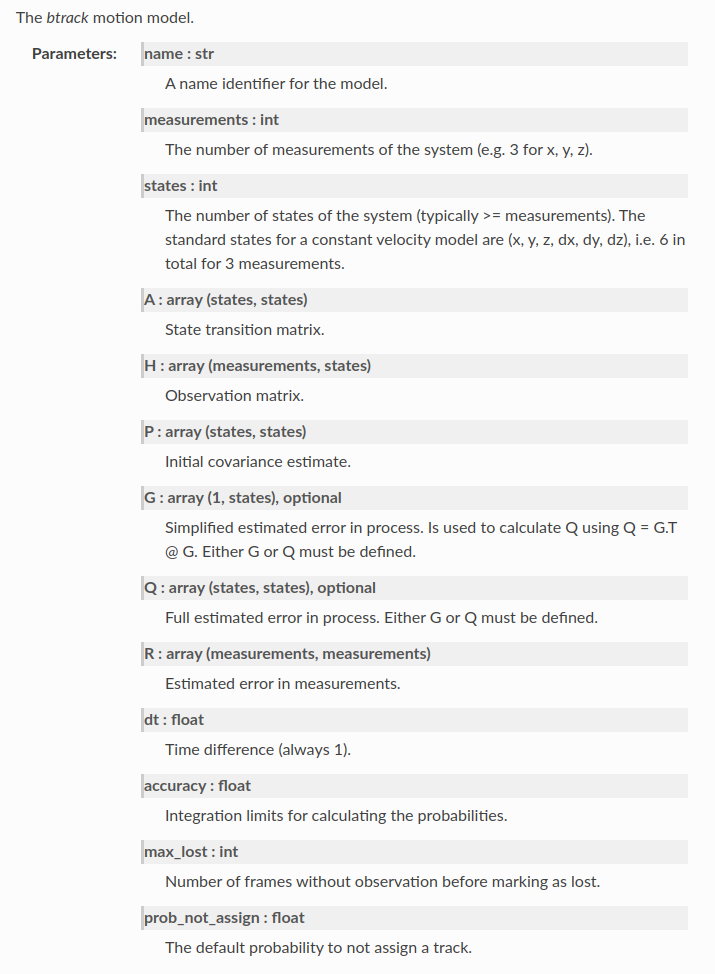